## Predicting Starcraft Player Ranks Using Performance Data
Name - Swati 

Email - swati@tamu.edu

### Step 0 : Importing necessary librarires

In [855]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from scipy.special import boxcox1p
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

### Step 1 : Data Extraction

In [856]:
#Load the Dataset in the pandas dataframe
df = pd.read_csv('starcraft_player_data.csv')
#display the dataset.
df

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.718,0.004,0.000,7,0.000,0.000,0.005,32.668,40.867,4.751,28,0.001,6,0.000,0.000
1,55,5,23,10,5000,129.232,0.003,0.000,4,0.000,0.000,0.004,32.919,42.345,4.843,22,0.001,5,0.000,0.000
2,56,4,30,10,200,69.961,0.001,0.000,4,0.000,0.000,0.003,44.648,75.355,4.043,22,0.001,6,0.000,0.000
3,57,3,19,20,400,107.602,0.001,0.000,1,0.000,0.001,0.004,29.220,53.735,4.915,19,0.000,7,0.000,0.000
4,58,3,32,10,500,122.891,0.001,0.000,2,0.000,0.001,0.002,22.689,62.081,9.374,15,0.001,4,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,10089,8,?,?,?,259.630,0.020,0.001,9,0.001,0.000,0.005,18.606,42.834,6.275,46,0.001,5,0.000,0.000
3391,10090,8,?,?,?,314.670,0.028,0.001,10,0.000,0.001,0.004,14.302,36.116,7.197,16,0.001,4,0.000,0.000
3392,10092,8,?,?,?,299.428,0.028,0.001,7,0.000,0.000,0.004,12.403,39.516,6.398,19,0.001,4,0.000,0.000
3393,10094,8,?,?,?,375.866,0.036,0.001,5,0.000,0.001,0.004,11.691,34.855,7.962,15,0.001,6,0.000,0.001


In [857]:
#display dimension of the datset
df.shape

(3395, 20)

#### There are total 3395 players we want to predict LeagueIndex and we haev 19 features. We have to perform the EDA to do prepare the final dataset. We do not have a training set and testing set, so we will have to split the data set.

### Step 2 : Data Cleaning

#### Handling Missing Values

In [858]:
# Funtion to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data

In [859]:
missing_val_check(df)

,Total,Percent(%)
GameID,0,0.000
LeagueIndex,0,0.000
ComplexUnitsMade,0,0.000
UniqueUnitsMade,0,0.000
WorkersMade,0,0.000
TotalMapExplored,0,0.000
ActionsInPAC,0,0.000
ActionLatency,0,0.000
GapBetweenPACs,0,0.000
NumberOfPACs,0,0.000


### Let's see the descriptive statistics for the categorical columns our data

In [860]:
display(df.describe(include=["O"]))

,Age,HoursPerWeek,TotalHours
count,3395,3395,3395
unique,29,33,238
top,20,10,500
freq,357,411,328


Age, HourPerWeek, TotalHours should be numeric data dtype. Being an object data type implies that something might be wrong is what we can suspect. Some unwanted characters might be in there is our hypothesis.

Lets look the unique values of Age, HoursPerWeek, TotalHours and see if we can detect any anomoly.

In [861]:
df["Age"].unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [862]:
df["HoursPerWeek"].unique()

array(['10', '20', '6', '8', '42', '14', '24', '16', '4', '12', '30',
       '28', '70', '2', '56', '36', '40', '18', '96', '50', '168', '48',
       '84', '0', '72', '112', '90', '32', '98', '140', '?', '80', '60'],
      dtype=object)

In [863]:
df["TotalHours"].unique()

array(['3000', '5000', '200', '400', '500', '70', '240', '10000', '2708',
       '800', '6000', '190', '350', '1000', '1500', '2000', '120', '1100',
       '2520', '700', '160', '150', '250', '730', '230', '300', '100',
       '270', '1200', '30', '600', '540', '280', '1600', '50', '140',
       '900', '550', '625', '1300', '450', '750', '612', '180', '770',
       '720', '415', '1800', '2200', '480', '430', '639', '360', '1250',
       '365', '650', '233', '416', '1825', '780', '1260', '315', '10',
       '312', '110', '1700', '92', '2500', '1400', '220', '999', '303',
       '96', '184', '4000', '420', '60', '2400', '2160', '80', '25',
       '624', '176', '?', '35', '1163', '333', '75', '7', '40', '325',
       '90', '175', '88', '850', '26', '1650', '465', '235', '1350',
       '460', '848', '256', '130', '1466', '670', '711', '1030', '1080',
       '1460', '1050', '20000', '582', '2800', '553', '1008', '330',
       '936', '243', '1320', '425', '1145', '366', '2700', '830', '3',
 

In the given DataFrame, it appears that there are certain values represented as "?" in the columns, causing them to be treated as object (string) type by pandas. To perform any analysis on these columns, it is necessary to convert them back to numeric type. To achieve this, we can replace the "?" values with null or NaN values, and then treat them accordingly.

In [864]:
df.replace('?', np.nan, inplace=True)
df['Age'] = df['Age'].astype(float)
df['HoursPerWeek'] = df['HoursPerWeek'].astype(float)
df['TotalHours'] = df['TotalHours'].astype(float)
missing_val_check(df)

,Total,Percent(%)
TotalHours,57,1.679
HoursPerWeek,56,1.649
Age,55,1.620
GameID,0,0.000
GapBetweenPACs,0,0.000
ComplexUnitsMade,0,0.000
UniqueUnitsMade,0,0.000
WorkersMade,0,0.000
TotalMapExplored,0,0.000
ActionsInPAC,0,0.000


Upon inspection of the DataFrame, it is evident that the columns "Age," "TotalHours," and "HoursperWeek" contain missing values, accounting for approximately 1% of the data. These missing values can be handled through a process known as imputation. By applying intelligent imputation techniques, we can fill in the missing values in a meaningful way, ensuring the integrity of the data.

##### Let's now examine the distribution of age across different league indices. By analyzing the age distribution for each league index category, we can gain insights into the age demographics within different skill levels of the gaming community. This exploration will provide a clearer understanding of how age is distributed across various league indices.

In [865]:
df[df["Age"].isnull()].head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,NaN,NaN,NaN,189.740,0.005,0.001,4,0.000,0.001,0.006,23.513,32.566,4.445,25,0.002,6,0.000,0.000
3341,10005,8,NaN,NaN,NaN,287.813,0.029,0.001,9,0.000,0.001,0.005,31.642,36.114,4.589,34,0.001,6,0.000,0.000
3342,10006,8,NaN,NaN,NaN,294.100,0.030,0.001,6,0.000,0.002,0.006,16.639,36.819,4.185,26,0.001,6,0.000,0.000
3343,10015,8,NaN,NaN,NaN,274.255,0.018,0.001,8,0.000,0.001,0.007,10.642,24.356,4.387,28,0.001,6,0.000,0.000
3344,10016,8,NaN,NaN,NaN,274.340,0.023,0.001,8,0.001,0.004,0.005,19.157,36.310,5.281,28,0.001,6,0.000,0.000


In [866]:
df[df["Age"].isnull()]["LeagueIndex"].unique()

array([8])

Based on the observation, it appears that the missing values in the "Age" column align with the instances where the corresponding "leagueindex" value is 8.

To impute the missing value in the "Age" column intelligently, we can examine the distribution of ages based on the different values of the "leagueIndex" variable. By analyzing the age distribution within each league index category, we can gain insights that will help us make an informed decision on how to impute the missing value appropriately.

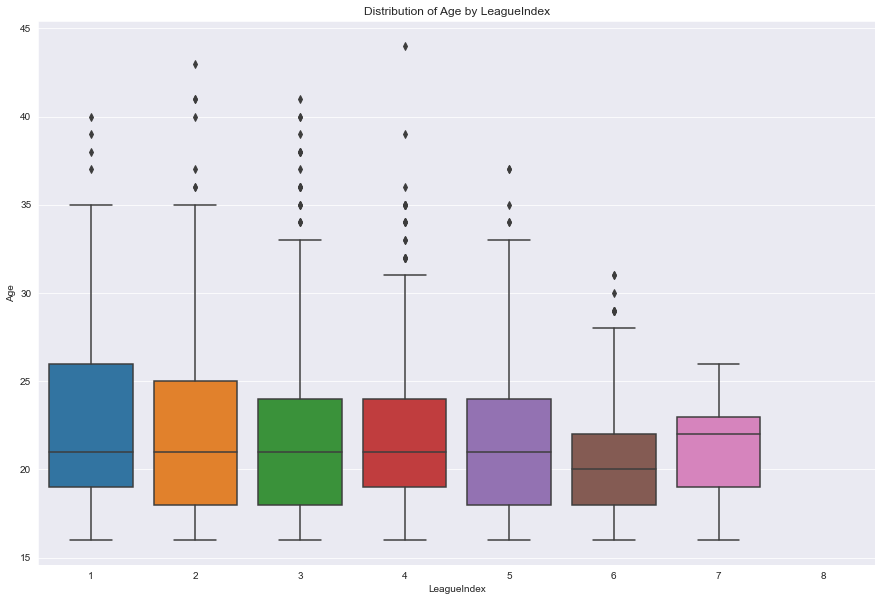

In [867]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="LeagueIndex", y="Age")
plt.title("Distribution of Age by LeagueIndex")
plt.xlabel("LeagueIndex")
plt.ylabel("Age")
plt.show()

Based on the visualization of the age distribution by league index, it is apparent that higher league indices tend to have a larger proportion of younger players. This observation aligns with the notion that younger individuals often possess better stamina, reflexes, and gaming-related muscle memory, which can contribute to their success in gaming. Consequently, it would be reasonable to replace the missing age values for instances with a league index of 8 with the median age of the players in league index 7. This approach takes into consideration the age characteristics of players in a similar skill level and ensures a more accurate imputation of the missing age values.

In [868]:
median_value = df[df["LeagueIndex"] == 7]["Age"].median()
df["Age"] = df["Age"].fillna(median_value)

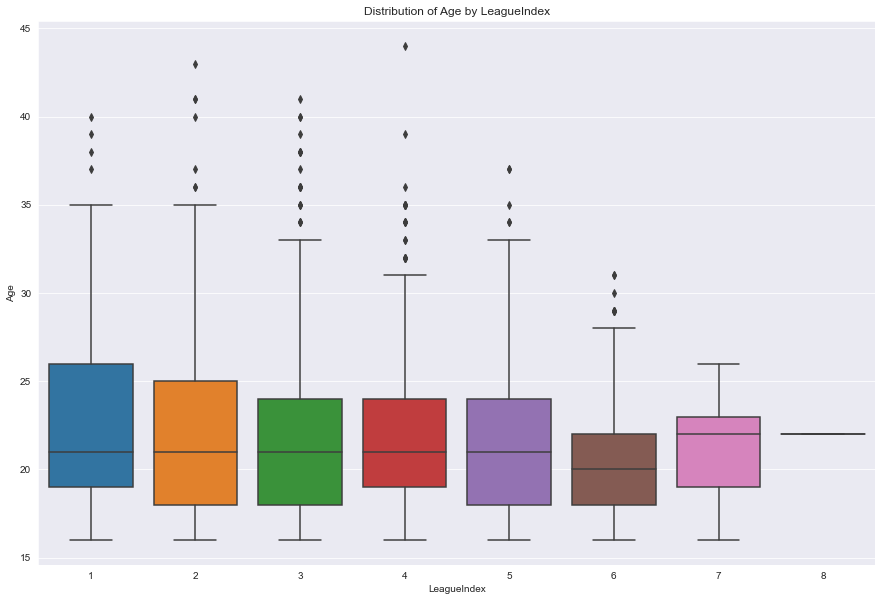

In [869]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="LeagueIndex", y="Age")
plt.title("Distribution of Age by LeagueIndex")
plt.xlabel("LeagueIndex")
plt.ylabel("Age")
plt.show()

##### Let's now explore the distribution of the "TotalHours" variable across different league indices. By analyzing how the total hours played varies for each league index category, we can gain valuable insights into the overall gaming experience and commitment levels of players at different skill levels. This examination will allow us to understand the variations in total gaming hours among various league indices.

In [870]:
df[df["TotalHours"].isnull()]["LeagueIndex"].unique()

array([5, 8])

Based on the observation, it appears that the missing values in the "TotalHours" column align with the instances where the corresponding "leagueindex" value is 5 and 8.

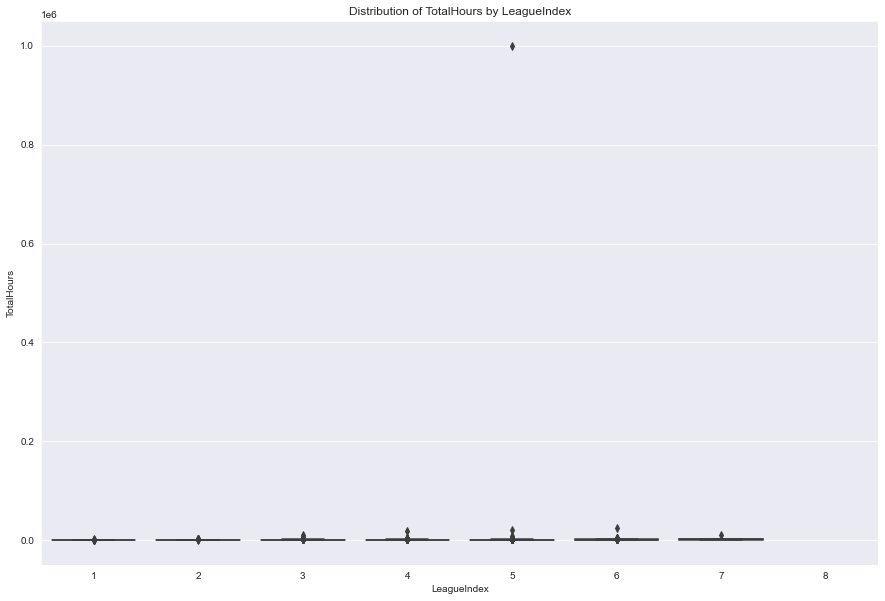

In [871]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="LeagueIndex", y="TotalHours")
plt.title("Distribution of TotalHours by LeagueIndex")
plt.xlabel("LeagueIndex")
plt.ylabel("TotalHours")
plt.show()

Based on the analysis of the "TotalHours" variable across different league indices, we can proceed with imputing the missing values using the median of total hours from league indices 5, 6, and 7. By taking the median of these leagues, we can ensure that the imputed values align with the typical total hours played by players in similar skill levels. This approach allows us to maintain consistency with the observed patterns in the dataset.

In [872]:
med_val_l6l7 = df.loc[df["LeagueIndex"].between(5, 7), "TotalHours"].median()
df.loc[df["TotalHours"].isnull(), "TotalHours"] = med_val_l6l7

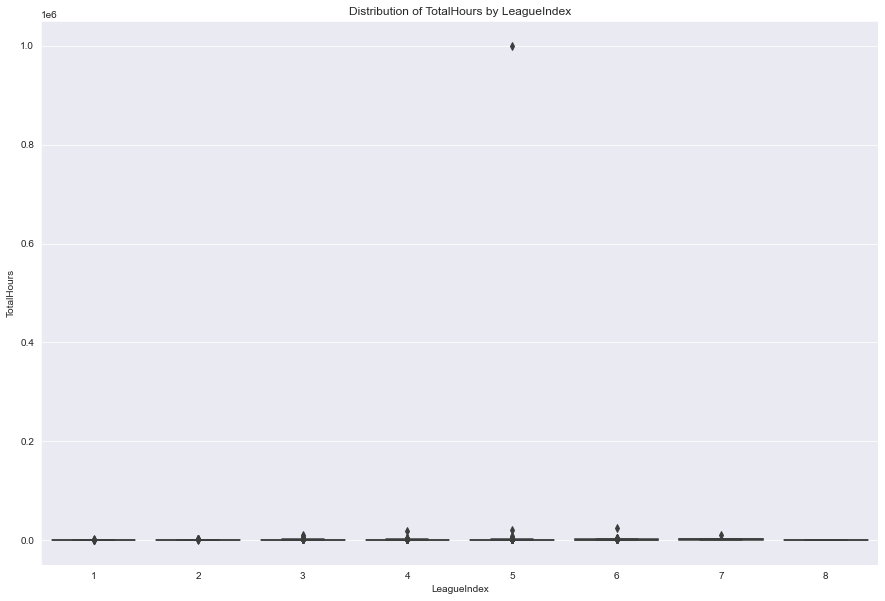

In [873]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="LeagueIndex", y="TotalHours")
plt.title("Distribution of TotalHours by LeagueIndex")
plt.xlabel("LeagueIndex")
plt.ylabel("TotalHours")
plt.show()

##### Let's now investigate the distribution of "HoursPerWeek" across different league indices. By examining how the number of hours spent per week on gaming varies for each league index category, we can gain valuable insights into the time commitment and dedication levels of players at different skill levels. This analysis will provide a better understanding of the variations in gaming hours among various league indices.

In [874]:
df[df["HoursPerWeek"].isnull()]["LeagueIndex"].unique()

array([5, 8])

Based on the observation, it appears that the missing values in the "HoursPerWeek" column align with the instances where the corresponding "leagueindex" value is 5 and 8.

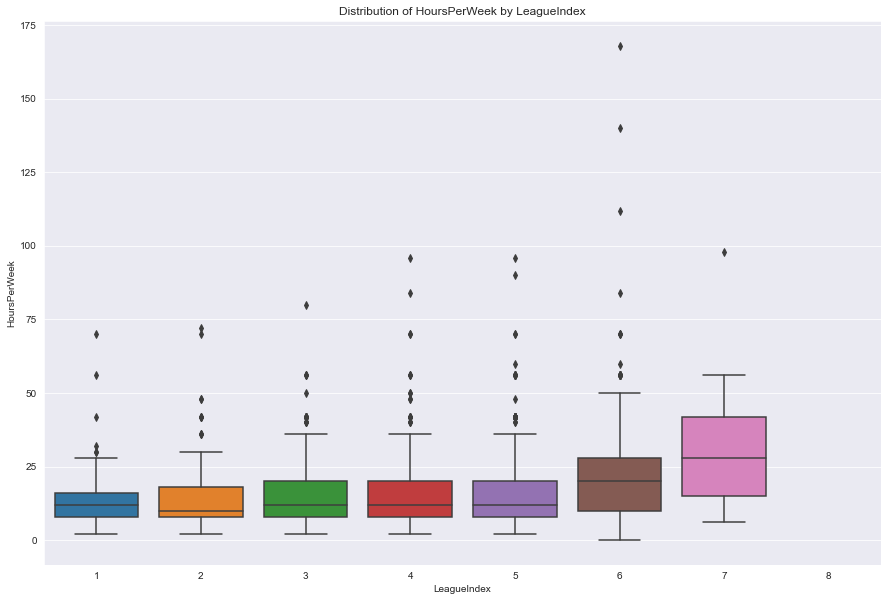

In [875]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="LeagueIndex", y="HoursPerWeek")
plt.title("Distribution of HoursPerWeek by LeagueIndex")
plt.xlabel("LeagueIndex")
plt.ylabel("HoursPerWeek")
plt.show()

Based on the observed trend in the data, it is clear that players with higher league indices generally spend more time playing. Therefore, it is logical to impute the missing values for "HoursPerWeek" differently based on the league index. For instances with a league index of 8, we can consider imputing the missing values with a value close to the median of players in league index 7. Similarly, for instances with a league index of 5, we can impute the missing values using the median of players in league index 5. By imputing the missing values in this manner, we ensure that the imputed values align with the typical time commitment of players in their respective skill levels, maintaining consistency with the observed patterns in the dataset.

In [876]:
# Imputing the missing value for players with a league index of 5
med_val_l5 = df.loc[df["LeagueIndex"] == 5, "HoursPerWeek"].median()
df.loc[(df["HoursPerWeek"].isnull()) & (df["LeagueIndex"] == 5), "HoursPerWeek"] = med_val_l5

# Imputing the missing value for players with a league index of 8
med_val_l8 = df.loc[df["LeagueIndex"] == 7, "HoursPerWeek"].median()
df.loc[(df["HoursPerWeek"].isnull()) & (df["LeagueIndex"] == 8), "HoursPerWeek"] = med_val_l8

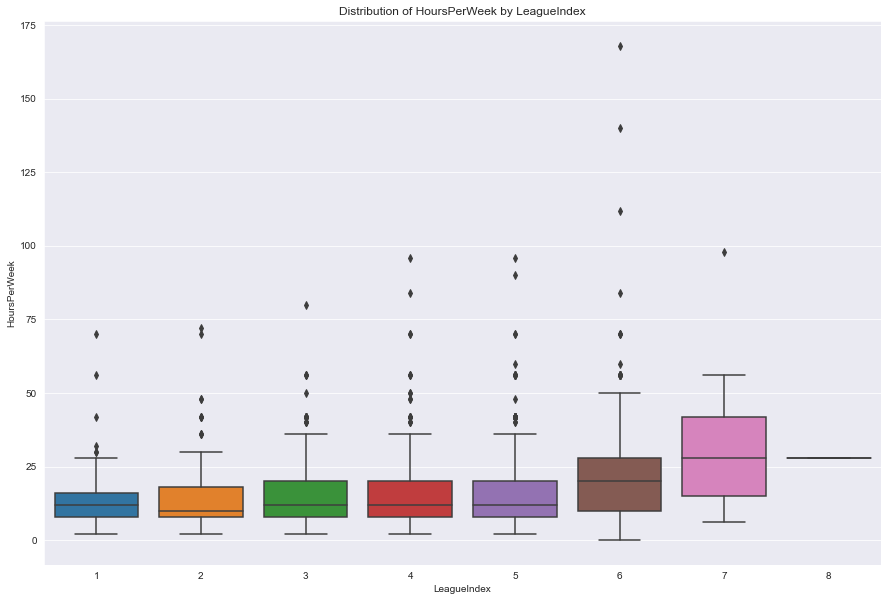

In [877]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="LeagueIndex", y="HoursPerWeek")
plt.title("Distribution of HoursPerWeek by LeagueIndex")
plt.xlabel("LeagueIndex")
plt.ylabel("HoursPerWeek")
plt.show()

In [878]:
print("Total missing values now are {}".format(df.isnull().sum().sum()))

Total missing values now are 0


In [879]:
df.columns

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'],
      dtype='object')

#### Outlier Treatament

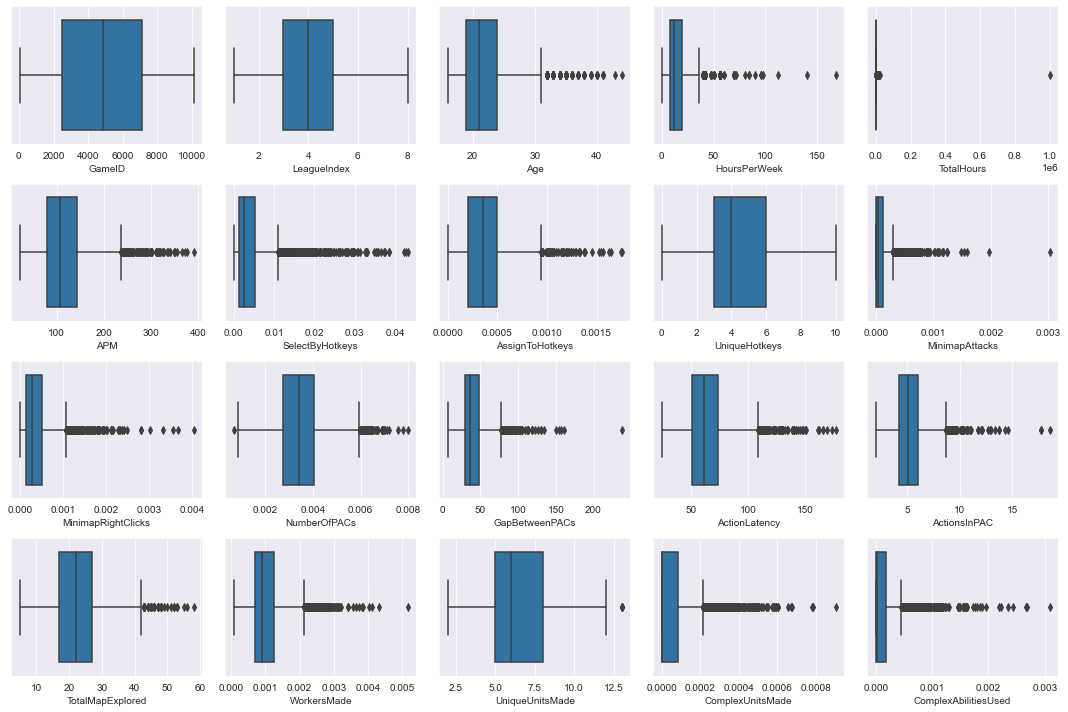

In [880]:
plt.figure(figsize=(15, 10))

for column in df.columns:
    plt.subplot(4, 5, df.columns.get_loc(column) + 1)
    sns.boxplot(x=column, data=df)
    plt.xlabel(column)

plt.tight_layout()
plt.show()

Key Obervations :
1. It is important to identify and treat outliers in the data. Some outliers may be valid while others could be erroneous entries. Before taking any action, it is crucial to consult with the relevant stakeholders to verify the legitimacy of the outliers. Values that are clearly impossible can be addressed directly.
2. Let's consider the "HoursPerWeek" column as an example. We observe an outlier value of 168, which equates to 24 hours multiplied by 7 days. It is highly unlikely for any player to consistently play for 24 hours a day, 7 days a week without taking breaks. As an assumption, let's consider that a player takes at least a 2-hour break per day. Therefore, we can replace all values greater than 154 with 154, which allows for reasonable gameplay hours per week.
3. Similarly, let's analyze the "TotalHours" column. We encounter a value of 1,000,000 hours, which appears to be an anomaly. Considering that the average total hours played is around 6,720, we can assume that some players may engage in extended gaming sessions. However, to maintain a reasonable range, we can replace values greater than 25,000 with 25,000. It is essential to cross-validate this threshold with a comprehensive dataset of players' historical total hours played to ensure accurate input for our model.
4. Other features related to players' attributes may also exhibit outliers, which could be valid considering exceptional skills and abilities of certain players. However, it is advisable to verify these outliers with scientific facts or domain knowledge before deciding whether they require treatment.
5. Additionally, we notice that the "ComplexUnitsMade" and "ComplexAbilitiesUsed" columns have minimum values of 0. While this could potentially raise concerns, it is plausible during a game for players to have instances where they do not utilize complex units or abilities. As such, we will leave these values unchanged for now. However, it is recommended to consult with the business stakeholders to determine if a 0 value is plausible in real-life scenarios.

Please note that these outlier treatment decisions should be made in collaboration with the relevant domain experts or stakeholders to ensure accurate analysis and model fitting.

In [881]:
# Replacing HoursPerWeek values greater than 154 with 154
df.loc[df["HoursPerWeek"] > 154, "HoursPerWeek"] = 154

# Replacing anomalous TotalHours values greater than 25000 with 25000
df.loc[df["TotalHours"] > 25000, "TotalHours"] = 25000

<AxesSubplot:xlabel='HoursPerWeek'>

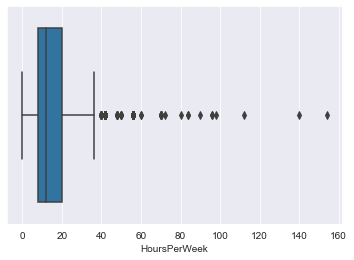

In [882]:
sns.boxplot(x="HoursPerWeek", data=df)

<AxesSubplot:xlabel='TotalHours'>

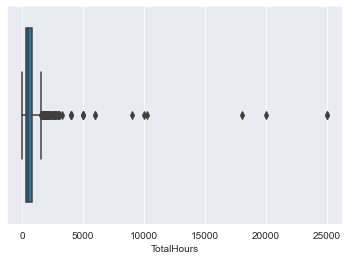

In [883]:
sns.boxplot(x="TotalHours", data=df)

### Step 3 : Defining Features and Target Variable

In [884]:
y = df.LeagueIndex
X = df.drop(columns='LeagueIndex')
y.value_counts()

4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

### Step 4: Check the Distribution and Skewness

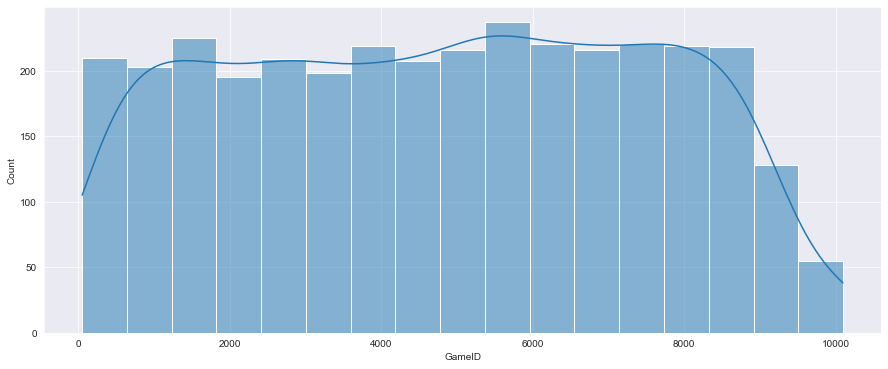

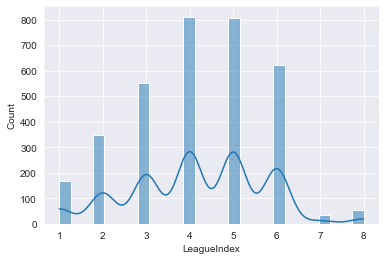

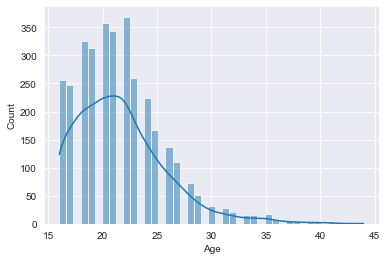

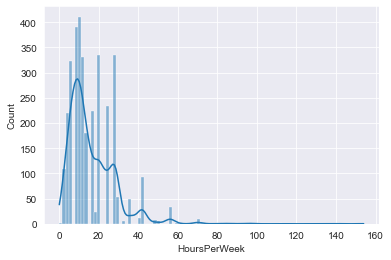

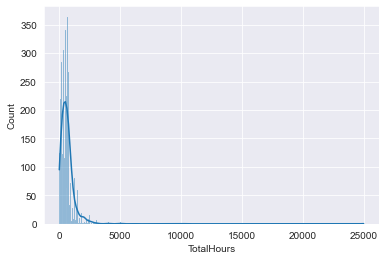

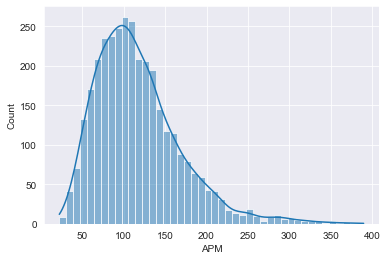

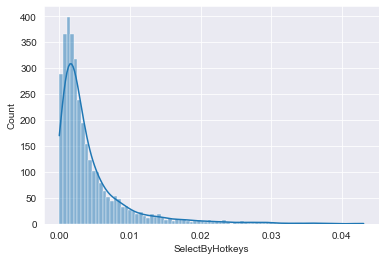

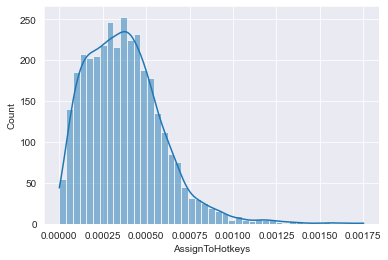

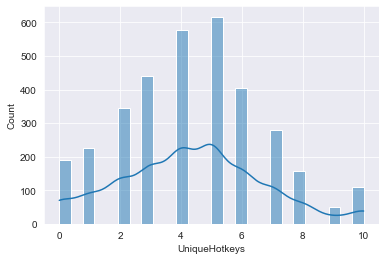

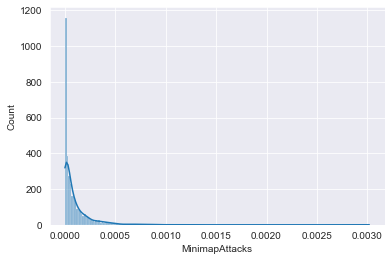

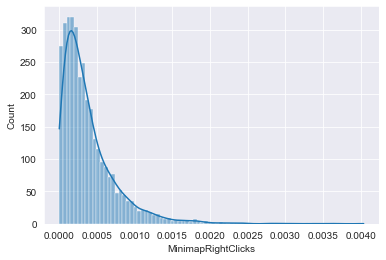

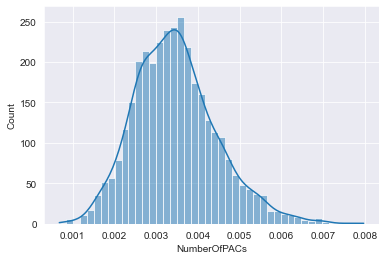

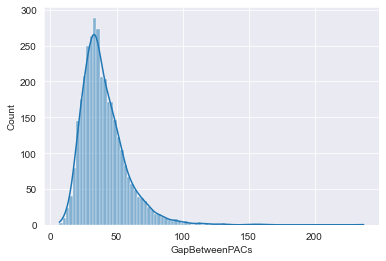

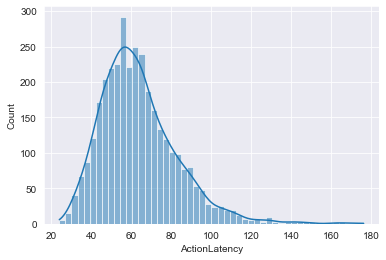

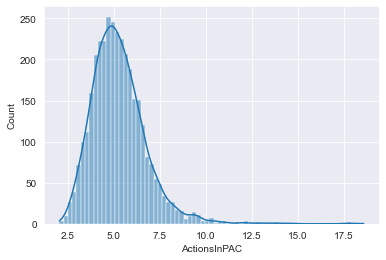

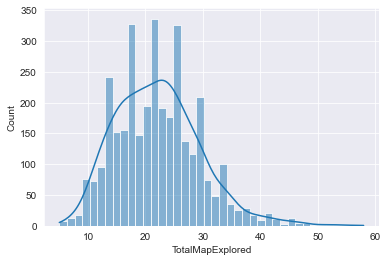

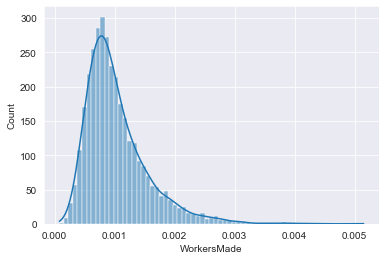

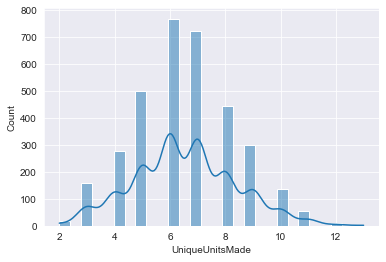

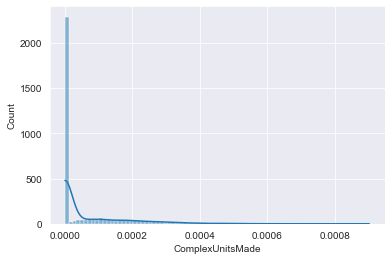

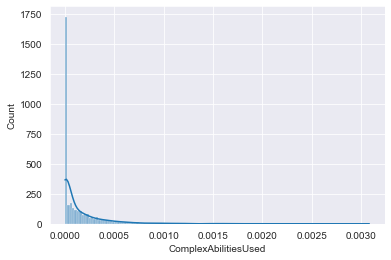

In [885]:
plt.figure(figsize=(15, 6))

for feature in df.columns:
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.show()

Data Looks normally distributed for most of the features but some features looks skewed. Hence plotting the QQ lot to better look into the skewness

<Figure size 1080x864 with 0 Axes>

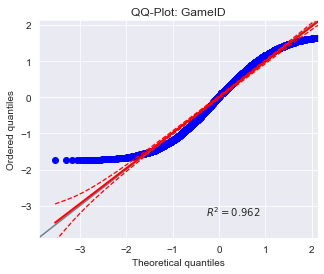

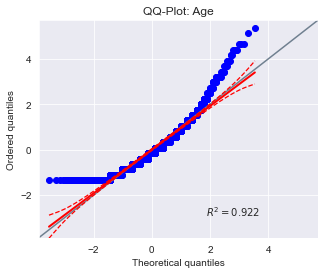

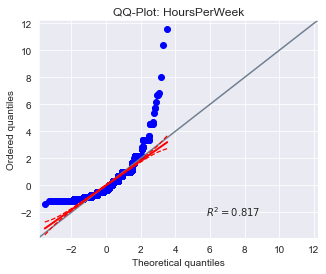

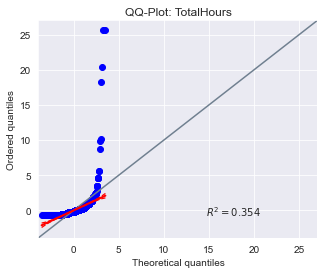

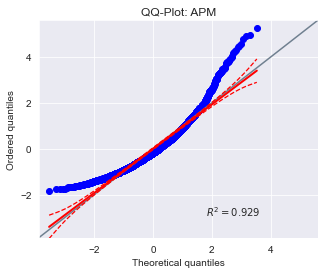

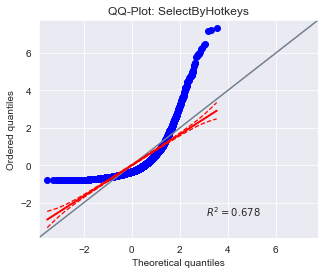

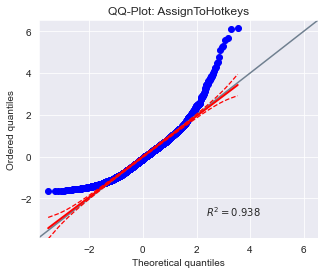

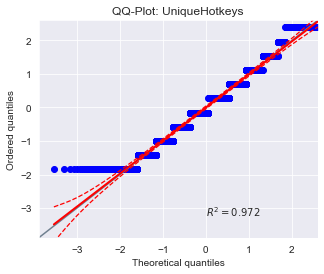

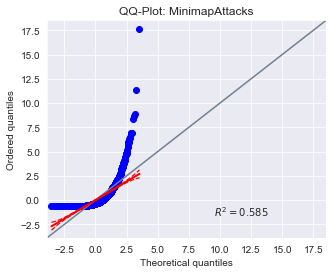

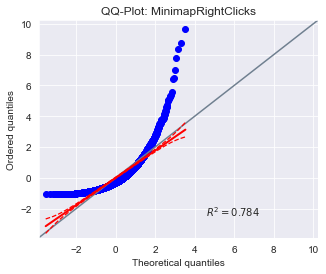

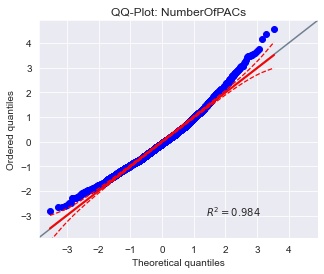

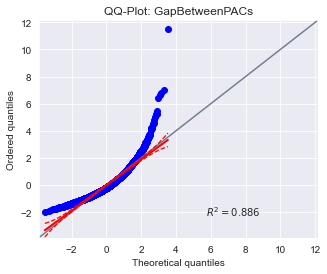

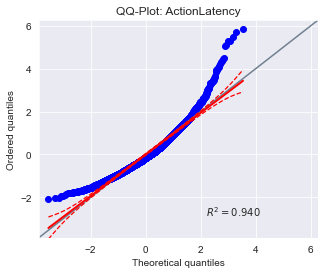

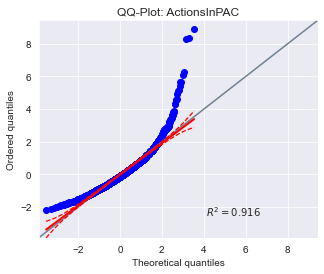

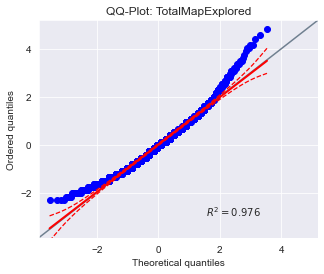

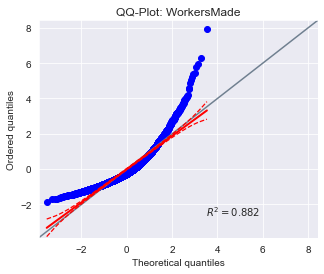

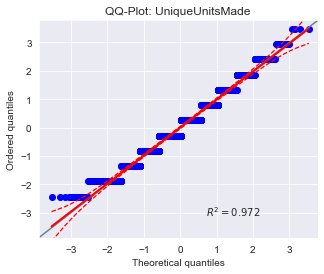

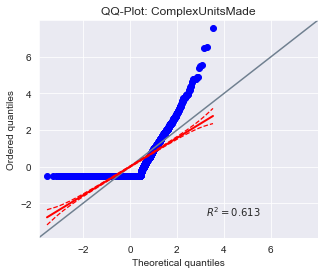

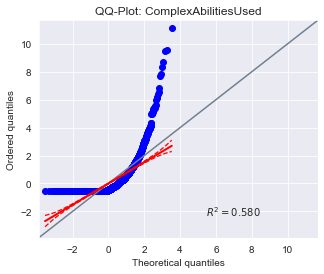

In [886]:
plt.figure(figsize=(15, 12))

for i, feature in enumerate(X.columns):
    pg.qqplot(df[feature])
    plt.title(f"QQ-Plot: {feature}")

plt.show()

In [887]:
numeric_feats = X.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)


Skew in numerical features: 



,Skew
MinimapAttacks,4.817
ComplexAbilitiesUsed,3.777
SelectByHotkeys,2.964
MinimapRightClicks,2.563
ComplexUnitsMade,2.300
GapBetweenPACs,1.907
WorkersMade,1.661
ActionsInPAC,1.598
APM,1.204
ActionLatency,1.151


In [888]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Log-Log transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X[feat] = np.log1p(X[feat])

There are 16 skewed numerical features to Log-Log transform


We identify features that exhibit significant skewness by considering those with skewness values greater than 0.75.
We determine the number of numerical features that require transformation due to skewness.
To mitigate the skewness, we apply the log transformation using the np.log1p() function to the identified skewed features.
This transformation aims to bring the data distribution closer to a normal distribution, thereby potentially enhancing the performance of specific models.

<Figure size 1080x864 with 0 Axes>

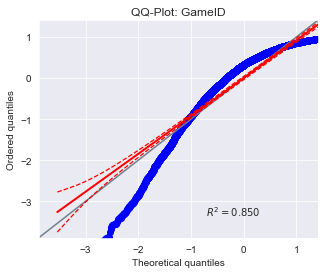

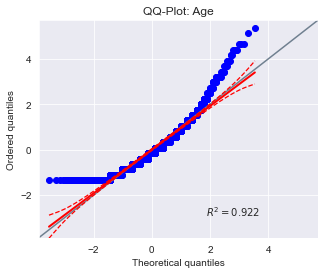

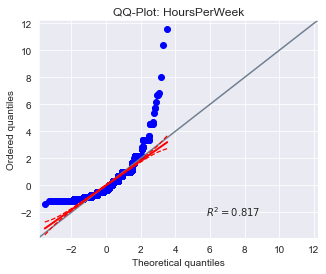

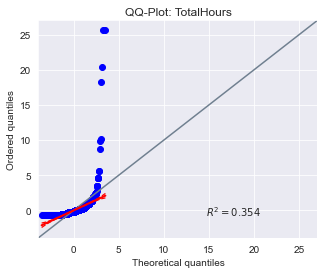

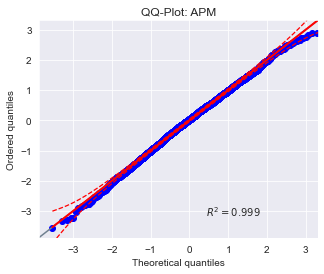

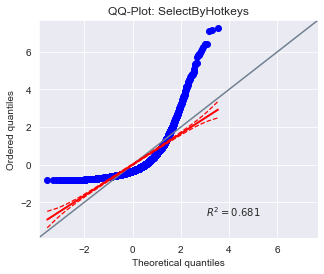

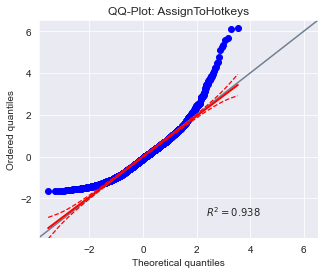

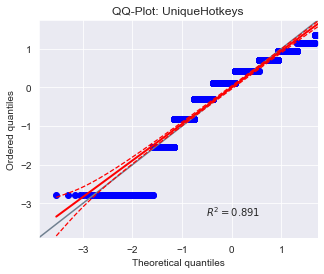

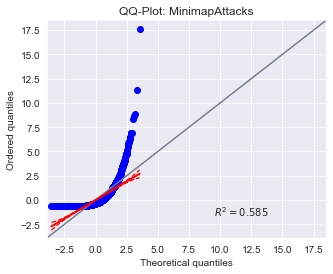

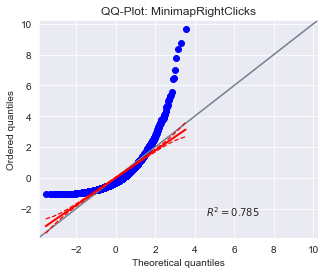

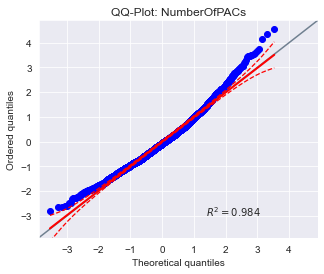

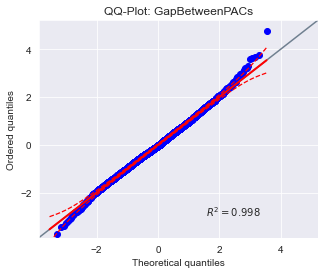

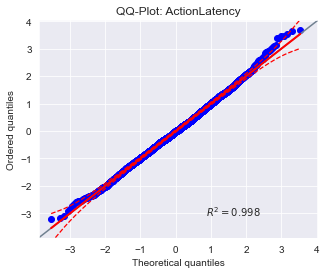

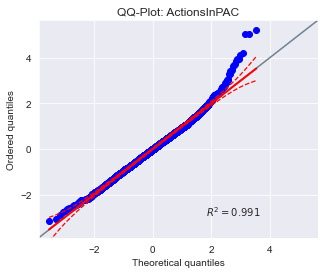

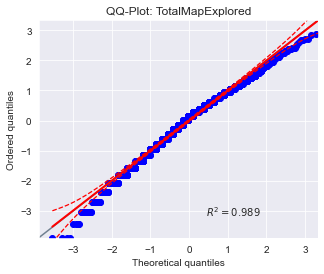

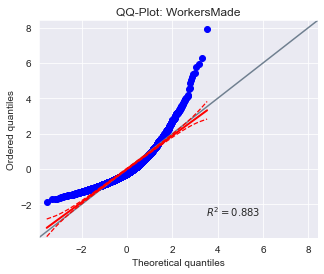

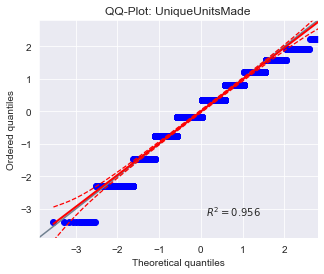

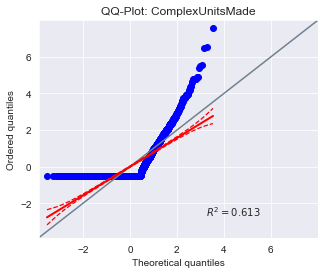

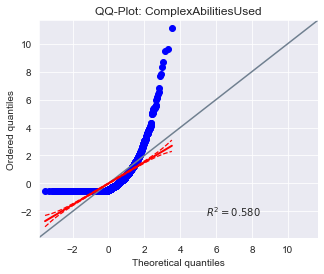

In [889]:
plt.figure(figsize=(15, 12))

for i, feature in enumerate(X.columns):
    pg.qqplot(X[feature])
    plt.title(f"QQ-Plot: {feature}")

plt.show()

### Step 4 : Normalizing Features

In [890]:
def normalize_data(data):
    scaler = preprocessing.MinMaxScaler()
    data_norm = scaler.fit_transform(data)
    
    # When the data has been transformed, a np.array is returned,
    # So we have to convert it back to a dataframe, and insert column names
    return pd.DataFrame(data_norm, columns=data.columns)
    
X = normalize_data(X)
X.describe()

,GameID,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000,3395.000
mean,0.805,0.202,0.105,0.027,0.545,0.101,0.213,0.648,0.033,0.096,0.383,0.469,0.464,0.376,0.567,0.189,0.577,0.066,0.046
std,0.174,0.149,0.077,0.038,0.153,0.124,0.128,0.233,0.055,0.093,0.136,0.112,0.146,0.120,0.145,0.102,0.169,0.123,0.086
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.731,0.107,0.052,0.012,0.443,0.030,0.117,0.578,0.000,0.035,0.285,0.397,0.367,0.296,0.481,0.120,0.450,0.000,0.000
50%,0.861,0.179,0.078,0.020,0.549,0.059,0.201,0.671,0.013,0.070,0.373,0.464,0.462,0.374,0.588,0.164,0.550,0.000,0.007
75%,0.933,0.286,0.130,0.032,0.647,0.121,0.285,0.812,0.039,0.127,0.460,0.542,0.558,0.451,0.674,0.233,0.713,0.095,0.059
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### Step 3 : Feature Selection

<AxesSubplot:>

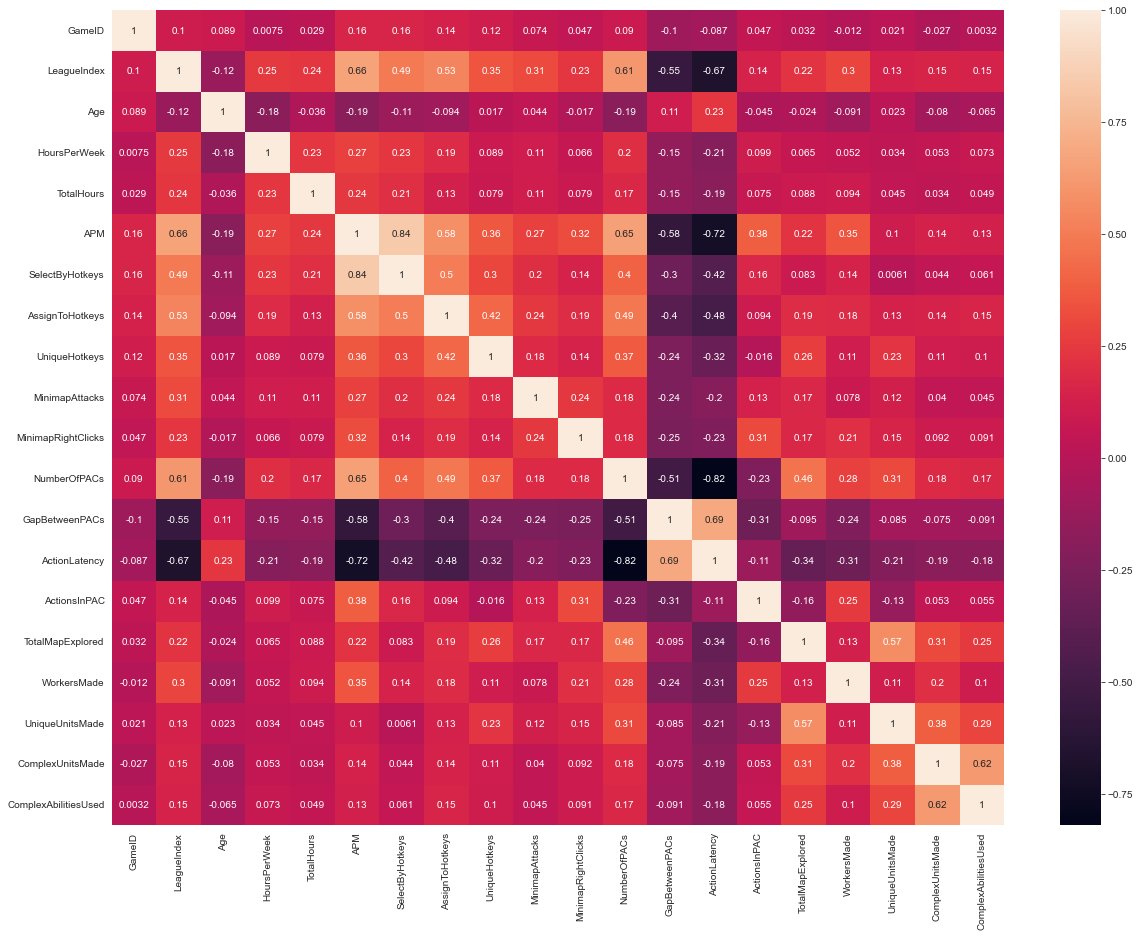

In [891]:
#Correlation map to see how features are correlated with LeagueIndex
plt.figure(figsize=(20, 15))
corr = df.corr()
sns.heatmap(corr, annot=True)

In [892]:
corr

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,1.000,0.103,0.089,0.008,0.029,0.160,0.161,0.136,0.117,0.074,0.047,0.090,-0.103,-0.087,0.047,0.032,-0.012,0.021,-0.027,0.003
LeagueIndex,0.103,1.000,-0.118,0.246,0.237,0.662,0.491,0.531,0.351,0.313,0.233,0.612,-0.553,-0.674,0.143,0.221,0.296,0.134,0.149,0.146
Age,0.089,-0.118,1.000,-0.182,-0.036,-0.189,-0.112,-0.094,0.017,0.044,-0.017,-0.188,0.109,0.234,-0.045,-0.024,-0.091,0.023,-0.080,-0.065
HoursPerWeek,0.008,0.246,-0.182,1.000,0.234,0.273,0.233,0.187,0.089,0.107,0.066,0.197,-0.152,-0.208,0.099,0.065,0.052,0.034,0.053,0.073
TotalHours,0.029,0.237,-0.036,0.234,1.000,0.242,0.206,0.128,0.079,0.114,0.079,0.174,-0.148,-0.194,0.075,0.088,0.094,0.045,0.034,0.049
APM,0.160,0.662,-0.189,0.273,0.242,1.000,0.841,0.578,0.362,0.271,0.322,0.651,-0.575,-0.722,0.384,0.221,0.350,0.101,0.136,0.132
SelectByHotkeys,0.161,0.491,-0.112,0.233,0.206,0.841,1.000,0.505,0.302,0.197,0.143,0.399,-0.304,-0.415,0.163,0.083,0.142,0.006,0.044,0.061
AssignToHotkeys,0.136,0.531,-0.094,0.187,0.128,0.578,0.505,1.000,0.420,0.242,0.193,0.487,-0.397,-0.482,0.094,0.193,0.183,0.133,0.145,0.154
UniqueHotkeys,0.117,0.351,0.017,0.089,0.079,0.362,0.302,0.420,1.000,0.181,0.142,0.372,-0.243,-0.323,-0.016,0.265,0.108,0.225,0.110,0.102
MinimapAttacks,0.074,0.313,0.044,0.107,0.114,0.271,0.197,0.242,0.181,1.000,0.242,0.177,-0.238,-0.200,0.135,0.166,0.078,0.121,0.040,0.045


In [893]:
# Select columns with correlation >= |0.3| with the target variable (excluding target variable)
target_corr = (corr["LeagueIndex"].abs() >= 0.3) & (corr.index != "LeagueIndex")
selected_columns = corr[target_corr].index.tolist()

# Display selected columns
print("Columns with correlation >= |0.3| with the target variable (excluding target variable):")
print(selected_columns)
X = X[selected_cols]

Columns with correlation >= |0.3| with the target variable (excluding target variable):
['APM', 'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency']


The purpose of this feature selection process is to identify the key features that show a notable correlation with the target variable. By choosing these features, we can narrow down our focus to the subset of variables that are likely to have a substantial impact on predicting the target variable, "LeagueIndex". In this step, we specifically select the features that have a correlation equal to or greater than |0.3| with the target variable, ensuring that we consider only the most influential features for our analysis.

### Step 4 : Train Test Split

Lets split this to a training and testing set

In [894]:

#['LeagueIndex', 'Age', 'HoursPerWeek', 'APM','MinimapAttacks','TotalMapExplored','WorkersMade','ComplexAbilitiesUsed','SelectByHotkeys','AssignToHotkeys']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

Lets check the size of all of these

In [895]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2716, 6)
(679, 6)
(2716,)
(679,)


### Step 5 : Model Buliding

In [896]:
#Logistic Regression
m1=LogisticRegression()
m1.fit(X_train,y_train)
y_pred_lr=m1.predict(X_test)
Train_Score_lr = m1.score(X_train,y_train)
Test_Score_lr = accuracy_score(y_test,y_pred_lr)


print('Training Accuracy is:',Train_Score_lr)
print('Testing Accuracy is:',Test_Score_lr)
print(classification_report(y_test,y_pred_lr))

Training Accuracy is: 0.38807069219440354
Testing Accuracy is: 0.3858615611192931
              precision    recall  f1-score   support

           1       0.70      0.21      0.33        33
           2       0.38      0.26      0.31        70
           3       0.32      0.21      0.25       111
           4       0.33      0.51      0.40       162
           5       0.38      0.43      0.40       161
           6       0.52      0.48      0.50       124
           7       0.00      0.00      0.00         7
           8       1.00      0.27      0.43        11

    accuracy                           0.39       679
   macro avg       0.45      0.30      0.33       679
weighted avg       0.40      0.39      0.38       679



In [897]:
m2 = KNeighborsClassifier()
m2.fit(X_train,y_train)
y_pred_knn = m2.predict(X_test)
Train_Score_knn = m2.score(X_train,y_train)
Test_Score_knn = accuracy_score(y_test,y_pred_knn)

print('Training Accuracy is :',Train_Score_knn)
print('Testing Accuracy is:',Test_Score_knn)
print(classification_report(y_test,y_pred_knn))

Training Accuracy is : 0.5246686303387335
Testing Accuracy is: 0.3225331369661267
              precision    recall  f1-score   support

           1       0.32      0.36      0.34        33
           2       0.19      0.23      0.21        70
           3       0.30      0.27      0.28       111
           4       0.31      0.36      0.33       162
           5       0.32      0.32      0.32       161
           6       0.46      0.36      0.41       124
           7       0.00      0.00      0.00         7
           8       0.75      0.55      0.63        11

    accuracy                           0.32       679
   macro avg       0.33      0.31      0.32       679
weighted avg       0.33      0.32      0.32       679



In [898]:
m3=BernoulliNB()
m3.fit(X_train,y_train)
y_pred_bnb=m3.predict(X_test)
Train_Score_bnb = m3.score(X_train,y_train)
Test_Score_bnb = accuracy_score(y_test,y_pred_bnb)

print('Training Accuracy :',Train_Score_bnb)
print('Testing Accuracy  :',Test_Score_bnb)
print(classification_report(y_test,y_pred_bnb))

Training Accuracy : 0.23969072164948454
Testing Accuracy  : 0.23858615611192932
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00       111
           4       0.24      1.00      0.39       162
           5       0.00      0.00      0.00       161
           6       0.00      0.00      0.00       124
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        11

    accuracy                           0.24       679
   macro avg       0.03      0.12      0.05       679
weighted avg       0.06      0.24      0.09       679



In [899]:
m4 = DecisionTreeClassifier()
m4.fit(X_train,y_train)
y_pred_dt=m4.predict(X_test)
Train_Score_dt = m4.score(X_train,y_train)
Test_Score_dt = accuracy_score(y_test,y_pred_dt)

print('Training Accuracy :',Train_Score_dt)
print('Testing Accuracy :',Test_Score_dt)
print(classification_report(y_test,y_pred_dt))

Training Accuracy : 1.0
Testing Accuracy : 0.27245949926362295
              precision    recall  f1-score   support

           1       0.13      0.12      0.12        33
           2       0.19      0.20      0.19        70
           3       0.22      0.23      0.23       111
           4       0.28      0.29      0.29       162
           5       0.28      0.25      0.26       161
           6       0.37      0.40      0.38       124
           7       0.17      0.14      0.15         7
           8       0.57      0.36      0.44        11

    accuracy                           0.27       679
   macro avg       0.28      0.25      0.26       679
weighted avg       0.27      0.27      0.27       679



In [900]:
m5 = RandomForestClassifier()
m5.fit(X_train,y_train)
y_pred_rf=m5.predict(X_test)
Train_Score_rf = m5.score(X_train,y_train)
Test_Score_rf = accuracy_score(y_test,y_pred_rf)

print('Training Accuracy :',Train_Score_rf)
print('Testing Accuracy :',Test_Score_rf)
print(classification_report(y_test,y_pred_rf))

Training Accuracy : 1.0
Testing Accuracy : 0.36524300441826213
              precision    recall  f1-score   support

           1       0.42      0.30      0.35        33
           2       0.29      0.29      0.29        70
           3       0.32      0.31      0.31       111
           4       0.31      0.36      0.33       162
           5       0.36      0.34      0.35       161
           6       0.49      0.52      0.51       124
           7       0.00      0.00      0.00         7
           8       0.67      0.55      0.60        11

    accuracy                           0.37       679
   macro avg       0.36      0.33      0.34       679
weighted avg       0.36      0.37      0.36       679



### Hyper Parameter Tuning

In [901]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]}

# instantiate the model
dtree = DecisionTreeClassifier(random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='accuracy')

In [902]:
tree.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 100,
 'min_samples_split': 50}

In [903]:
m6 = DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=100,min_samples_split=50)
m6.fit(X_train,y_train)
y_pred_tdt=m6.predict(X_test)
Train_Score_tdt = m6.score(X_train,y_train)
Test_Score_tdt = accuracy_score(y_test,y_pred_tdt)

print('Training Accuracy :',Train_Score_tdt)
print('Testing Accuracy  :',Test_Score_tdt)
print(classification_report(y_test,y_pred_tdt))

Training Accuracy : 0.38107511045655373
Testing Accuracy  : 0.35640648011782033
              precision    recall  f1-score   support

           1       0.42      0.45      0.43        33
           2       0.23      0.26      0.24        70
           3       0.32      0.24      0.28       111
           4       0.33      0.34      0.34       162
           5       0.37      0.47      0.41       161
           6       0.47      0.42      0.44       124
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        11

    accuracy                           0.36       679
   macro avg       0.27      0.27      0.27       679
weighted avg       0.35      0.36      0.35       679



In [904]:
#Gridsearch CV to find Optimal K value for KNN model
grid = {'n_neighbors':np.arange(1,50)}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn,grid,cv=3)
knn_cv.fit(X_train,y_train)


print("Tuned Hyperparameter k: {}".format(knn_cv.best_params_))

Tuned Hyperparameter k: {'n_neighbors': 46}


In [905]:
m7 = KNeighborsClassifier(n_neighbors=46)
m7.fit(X_train,y_train)
y_pred_tknn=m7.predict(X_test)
Train_Score_tknn = m7.score(X_train,y_train)
Test_Score_tknn = accuracy_score(y_test,y_pred_tknn)


print('Training Accuracy :',Train_Score_tknn)
print('Testing Accuracy  :',Test_Score_tknn)
print(classification_report(y_test,y_pred_tknn))

Training Accuracy : 0.422680412371134
Testing Accuracy  : 0.36671575846833576
              precision    recall  f1-score   support

           1       0.41      0.27      0.33        33
           2       0.31      0.31      0.31        70
           3       0.31      0.28      0.29       111
           4       0.33      0.44      0.38       162
           5       0.35      0.30      0.32       161
           6       0.50      0.51      0.50       124
           7       0.00      0.00      0.00         7
           8       1.00      0.36      0.53        11

    accuracy                           0.37       679
   macro avg       0.40      0.31      0.33       679
weighted avg       0.37      0.37      0.36       679



In [906]:
parameter={'n_estimators':np.arange(1,101)}
gs = GridSearchCV(m5,parameter,cv=3)
gs.fit(X_train,y_train)
gs.best_params_

{'n_estimators': 83}

In [909]:
m8 = RandomForestClassifier(n_estimators=83)
m8.fit(X_train,y_train) 
y_pred_trf=m8.predict(X_test)
Train_Score_trf = m8.score(X_train,y_train)
Test_Score_trf = accuracy_score(y_test,y_pred_trf)


print('Training Accuracy :',Train_Score_trf)
print('Testing Accuracy  :',Test_Score_trf)
print(classification_report(y_test,y_pred_trf))

Training Accuracy : 1.0
Testing Accuracy  : 0.36524300441826213
              precision    recall  f1-score   support

           1       0.44      0.33      0.38        33
           2       0.34      0.31      0.33        70
           3       0.32      0.33      0.33       111
           4       0.31      0.35      0.32       162
           5       0.35      0.37      0.36       161
           6       0.49      0.46      0.47       124
           7       0.00      0.00      0.00         7
           8       0.67      0.55      0.60        11

    accuracy                           0.37       679
   macro avg       0.37      0.34      0.35       679
weighted avg       0.37      0.37      0.37       679



### Step 6 : Model Evaluation

In [910]:
Model_Scores=pd.DataFrame({'Models':['Logistic Regression','KNN','Bernauli Naives Bayes','Decision Tree','Random Forest','Tuned Decison Tree','Tuned KNN','Tuned Random Forest'],
             'Training Accuracy':[Train_Score_lr,Train_Score_knn,Train_Score_bnb,Train_Score_dt,Train_Score_rf,Train_Score_tdt,Train_Score_tknn,Train_Score_trf],
             'Testing Accuracy':[Test_Score_lr,Test_Score_knn,Test_Score_bnb,Test_Score_dt,Test_Score_rf,Test_Score_tdt,Test_Score_tknn,Test_Score_trf],
                })

Model_Scores.sort_values(by=('Testing Accuracy'),ascending=False)

,Models,Training Accuracy,Testing Accuracy
0,Logistic Regression,0.388,0.386
6,Tuned KNN,0.423,0.367
4,Random Forest,1.000,0.365
7,Tuned Random Forest,1.000,0.365
5,Tuned Decison Tree,0.381,0.356
1,KNN,0.525,0.323
3,Decision Tree,1.000,0.272
2,Bernauli Naives Bayes,0.240,0.239


Hypothetical: after seeing your work, your stakeholders come to you and say that they can collect more data, but want your guidance before starting. How would you advise them based on your EDA and model results?


Based on the exploratory data analysis (EDA) and model results, it is evident that certain features, such as APM, SelectByHotkeys, AssignToHotkeys, UniqueHotkeys, MinimapAttacks, NumberOfPACs, GapBetweenPACs, ActionLatency exhibit significant correlations with the target variable, LeagueIndex. These findings suggest that collecting more data, specifically focusing on enhancing the representation of these strongly correlated features, could be beneficial for improving the models' predictive performance.

Therefore, my advice to the stakeholders would be to proceed with collecting additional data. However, it is crucial to prioritize gathering information that pertains to the features identified as having moderate to strong correlations with LeagueIndex. By doing so, we can enhance the representation of these important variables and potentially achieve higher accuracy and more reliable predictions.

By focusing on obtaining more data related to APM, SelectByHotkeys, AssignToHotkeys, UniqueHotkeys, MinimapAttacks, NumberOfPACs, GapBetweenPACs, ActionLatency, we can gain a deeper understanding of the impact of these features on a player's LeagueIndex. This expanded dataset would likely provide valuable insights and enable the development of more robust models that better capture the relationships between these features and the target variable.

In summary, based on the EDA and model results, it is recommended that the stakeholders collect more data, with a specific emphasis on the features demonstrating significant correlations with LeagueIndex. This approach has the potential to improve the accuracy and predictive performance of the models and provide a more comprehensive understanding of the factors influencing a player's LeagueIndex.